In [1]:
import Pkg; Pkg.add(Pkg.PackageSpec(url="https://github.com/JuliaComputing/JuliaAcademyData.jl"))
using JuliaAcademyData; activate("Foundations of machine learning")

   Updating git-repo `https://github.com/JuliaComputing/JuliaAcademyData.jl`


   Updating registry at `~/.juliapro/JuliaPro_v1.4.1-1/registries/JuliaPro`
  Resolving package versions...
   Updating `~/.juliapro/JuliaPro_v1.4.1-1/environments/v1.4/Project.toml`
 [no changes]
   Updating `~/.juliapro/JuliaPro_v1.4.1-1/environments/v1.4/Manifest.toml`
 [no changes]
 Activating environment at `~/.juliapro/JuliaPro_v1.4.1-1/packages/JuliaAcademyData/1to3l/courses/Foundations of machine learning/Project.toml`


## What is learning?

Computers read data, as we saw in notebooks 1 and 2. We can then build functions that model that data to make decisions, as we saw in notebooks 3 and 5.

But how do you make sure that the model actually fits the data well? In the last notebook, we saw that we can fiddle with the parameters of our function defining the model to reduce the loss function. However, we don't want to have to pick the model parameters ourselves. Choosing parameters ourselves works *well enough* when we have a simple model and only a few data points, but can quickly become extremely complex for more detailed models and larger data sets.

Instead, we want our machine to *learn* the parameters that fit the model to our data, without needing us to fiddle with the parameters ourselves. In this notebook, we'll talk about the "learning" in machine learning.

### Motivation: Fitting parameters by hand

Let's go back to our example of fitting parameters from notebook 3. Recall that we looked at whether the amount of green in the pictures could distinguish between an apple and a banana, and used a sigmoid function to model our choice of "apple or banana" using the amount of green in an image.

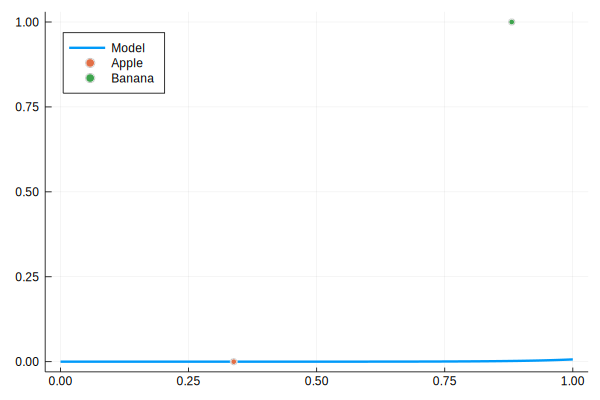

In [2]:
using Plots; gr()
using Images, Statistics

σ(x,w,b) = 1 / (1 + exp(-w*x+b))

apple =  load(datapath("data/10_100.jpg"))
banana = load(datapath("data/104_100.jpg"))
apple_green_amount =  mean(Float64.(green.(apple)))
banana_green_amount = mean(Float64.(green.(banana)));

w = 10.0 # Try manipulating w between 0 and 30 to see how the plot changes
b = 15.0 # Try manipulating b bewteen 0 and 30

plot(x->σ(x,w,b), 0, 1, label="Model", legend = :topleft, lw=3)
scatter!([apple_green_amount],  [0.0], label="Apple")
scatter!([banana_green_amount], [1.0], label="Banana")

Intuitively, how did you tweak the sliders so that way the model sends apples to 0 and bananas to 1? Most likely, you did the following:

#### Move the sliders a bit, see whether the curve moves in the right direction, and if it did, keep doing it.

For a machine, "learning" is that same process, translated into math!

## "Learning by nudging": The process of descent

Let's start to formalize this idea. In order to push the curve in the "right direction", we need some measurement of "how right" and "how wrong" the model is. When we translate the idea of a "right direction" into math, we end up with a **loss function**, `L(w, b)`, as we saw in notebook 5. We say that the loss function is lowest when the model `σ(x, w, b)` performs the best.

Now we want to create a loss function that is the lowest when the apple is at `0` and the banana is at `1`. If the data (the amount of green) for our apple is $x_1$, then our model will output $σ(x_1,w, b)$ for our apple. So, we want the difference $0 - σ(x_1, w, b)$ to be small. Similarly, if our data for our banana (the banana's amount of green) is $x_2$, we want the difference $1 - σ(x_2, w, b)$ to be small.

To create our loss function, let's add together the squares of the difference of the model's output from the desired output for the apple and the banana. We get

$$ L(w,b) = (0 - σ(x_1, w, b))^2 + (1 - σ(x_2, w, b))^2. $$

$L(w, b)$ is lowest when it outputs `0` for the apple and `1` for the banana, and thus the cost is lowest when the model "is correct".

We can visualize this function by plotting it in 3D with the `surface` function or in 2D with contour lines

In [3]:
# plotly() # The plotly backend is nice for 3d surface plots
gr() # The GR backend is good for faster interactive plots

Plots.GRBackend()

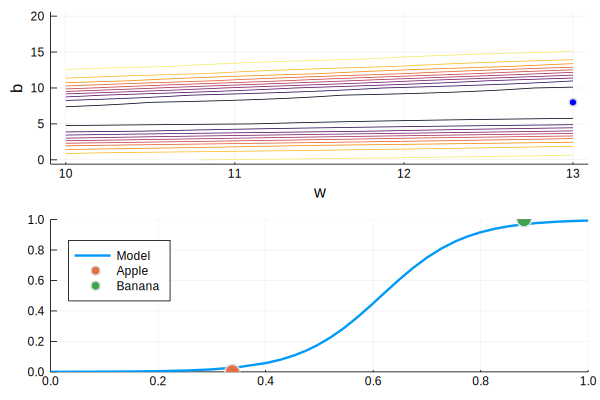

In [6]:
L(w, b) = (0 - σ(apple_green_amount,w,b))^2 + (1 - σ(banana_green_amount,w,b))^2

w_range = 10:0.1:13
b_range = 0:1:20

L_values = [L(w,b) for b in b_range, w in w_range]


w = 13.0 # Try manipulating w with values from w_range (between 10 and 13)
b = 8 # Try manipulating b with values from b_range (between 0 and 20)
#     p1 = surface(w_range, b_range, L_values, xlabel="w", ylabel="b", cam=(70,40), cbar=false, leg=false)
#     scatter!(p1, [w], [b], [L(w,b)+1e-2], markersize=5, color = :blue)
p1 = contour(w_range, b_range, L_values, levels=0.05:0.1:1, xlabel="w", ylabel="b", cam=(70,40), cbar=false, leg=false)
scatter!(p1, [w], [b], markersize=5, color = :blue)

p2 = plot(x->σ(x,w,b), 0, 1, label="Model", legend = :topleft, lw=3)
scatter!(p2, [apple_green_amount],  [0.0], label="Apple", markersize=10)
scatter!(p2, [banana_green_amount], [1.0], label="Banana", markersize=10, xlim=(0,1), ylim=(0,1))
plot(p1, p2, layout=(2,1))

The blue ball on the 3D plot shows the current parameter choices, plotted as `(w,b)`. Shown below the 3D plot is a 2D plot of the corresponding model with those parameters. Notice that as the blue ball rolls down the hill, the model becomes a better fit. Our loss function gives us a mathematical notion of a "hill", and the process of "learning by nudging" is simply rolling the ball down that hill.

To do this mathematically, we need to know which direction is "downhill". Recall from calculus that the derivative of `L` with respect to `b` tells you how `L` changes when `b` changes. Thus to roll downhill, we should go in the direction where the derivative is negative (the function goes down) for each parameter. This direction is the negative of what's called the **gradient**, $\nabla L$. This means that the "learn by nudging method" can be rephrased in mathematical terms as:

1. Calculate the gradient
2. Move a little bit in the direction of the negative gradient
3. Repeat

This process of rolling the ball in the direction of the negative gradient is called **gradient descent**; written mathematically, it is

$$p_{n+1} = p_n - \eta \nabla L(p_n).$$

Here, $p_n$ represents the vector of current parameters $(w, b)$; $\nabla L(p_n)$ is the gradient of the loss function, given those parameters. We start from $p_n$ and change it by $\eta \nabla L(p_n)$, where $\eta$ is a small step size that determines how far we move the parameters in the direction of the negative gradient; notice that if you step too far, you'll overshoot the minimum!. The result is $p_{n+1}$, the new vector of parameters.

[Picture of Gradient Descent Vectors]

If we repeat this process, then we will end up at parameters where the model correctly labels apples as `0` and bananas as `1`. When this happens, the model has learned from the data and can then read pictures and tell you whether they are apples or bananas!

#### Exercise 1

Use the following terms to fill in the sentences below. Terms may be used more than once or not at all:
> gradient, loss function, derivative, gradient descent, learning.

* We can think of a _(A)_ as a 1D version of a _(B)_.
* We can visualize a _(C)_ as a hill.
* In the explanation above, rolling downhill is called _(D)_ and means traveling along the _(E)_.
* To quantify the correctness of a model we use a _(F)_.
* When our program can minimize a _(G)_ on its own, we say it is _(H)_.

<br><br>

A) derivative <br>
B) gradient <br>
C) loss function <br>
D) gradient descent <br>
E) gradient <br>
F) loss function <br>
G) loss function <br>
H) learning<br>

#### Solution

A) derivative <br>
B) gradient <br>
C) loss function <br>
D) gradient descent <br>
E) gradient <br>
F) loss function <br>
G) loss function<br>
H) learning<br>